In [ ]:
!pip install pgmpy

     |████████████████████████████████| 337kB 22.0MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
network_file_name = 'drive/MyDrive/data/survey.bif'

In [ ]:
from pgmpy.readwrite import BIFReader
import numpy as np

reader = BIFReader(network_file_name)

In [ ]:
reader.get_values()

{'A': array([[0.3],
        [0.5],
        [0.2]]), 'E': array([[0.75, 0.64, 0.72, 0.7 , 0.88, 0.9 ],
        [0.25, 0.36, 0.28, 0.3 , 0.12, 0.1 ]]), 'O': array([[0.96, 0.92],
        [0.04, 0.08]]), 'R': array([[0.25, 0.2 ],
        [0.75, 0.8 ]]), 'S': array([[0.6],
        [0.4]]), 'T': array([[0.48, 0.58, 0.56, 0.7 ],
        [0.42, 0.24, 0.36, 0.21],
        [0.1 , 0.18, 0.08, 0.09]])}

In [ ]:
parents = reader.get_parents()
cpd = reader.get_values()
values = reader.get_states()

In [ ]:
variable_to_cpd = {}

for variable in reader.get_variables():
  v_parents = parents.get(variable)
  v_values = values.get(variable)
  v_cpd = cpd.get(variable)

  cpd_dict = {}
  if len(v_parents) == 0:
    for i in range(len(v_cpd)):
      if cpd_dict.get(v_values[i]) is None:
        cpd_dict[v_values[i]] = {}
      cpd_dict[v_values[i]][tuple()] = v_cpd[i][0]
  else:
    parent_values = []
    for parent_name in v_parents:
      parent_values.append(values[parent_name])

    all_combinations = np.array(np.meshgrid(*parent_values)).T.reshape(-1, len(v_parents))
    all_combinations = list(map(tuple, all_combinations))

    for i in range(len(v_cpd)):
      if cpd_dict.get(v_values[i]) is None:
        cpd_dict[v_values[i]] = {}
      for j in range(len(all_combinations)):
        cpd_dict[v_values[i]][all_combinations[j]] = v_cpd[i][j]

  variable_to_cpd[variable] = cpd_dict

for v_name, cpd in variable_to_cpd.items():
  print("CPD ", v_name, ": ", cpd)

CPD  A :  {'young': {(): 0.3}, 'adult': {(): 0.5}, 'old': {(): 0.2}}
CPD  S :  {'M': {(): 0.6}, 'F': {(): 0.4}}
CPD  E :  {'high': {('young', 'M'): 0.75, ('young', 'F'): 0.64, ('adult', 'M'): 0.72, ('adult', 'F'): 0.7, ('old', 'M'): 0.88, ('old', 'F'): 0.9}, 'uni': {('young', 'M'): 0.25, ('young', 'F'): 0.36, ('adult', 'M'): 0.28, ('adult', 'F'): 0.3, ('old', 'M'): 0.12, ('old', 'F'): 0.1}}
CPD  O :  {'emp': {('high',): 0.96, ('uni',): 0.92}, 'self': {('high',): 0.04, ('uni',): 0.08}}
CPD  R :  {'small': {('high',): 0.25, ('uni',): 0.2}, 'big': {('high',): 0.75, ('uni',): 0.8}}
CPD  T :  {'car': {('emp', 'small'): 0.48, ('emp', 'big'): 0.58, ('self', 'small'): 0.56, ('self', 'big'): 0.7}, 'train': {('emp', 'small'): 0.42, ('emp', 'big'): 0.24, ('self', 'small'): 0.36, ('self', 'big'): 0.21}, 'other': {('emp', 'small'): 0.1, ('emp', 'big'): 0.18, ('self', 'small'): 0.08, ('self', 'big'): 0.09}}


In [ ]:
variables = reader.get_variables()
values = reader.get_states()
parents = reader.get_parents()

In [ ]:
def calc_probability_deprecated(event = {}):
  for variable, value in event.items():
    values[variable] = [value]
  
  values_list = []
  for variable in variables:
    values_list.append(values[variable])
  
  all_combinations = np.array(np.meshgrid(*values_list)).T.reshape(-1, len(values))
  all_combinations = list(map(lambda x: {variables[i] : x[i] for i in range(len(values))}, all_combinations))

  result = 0.0

  for combination in all_combinations:
    temp_prob = 1.0
    for variable in variables:
      key = []
      for parent in parents[variable]:
        key.append(combination[parent])
      key = tuple(key)
      temp_prob = temp_prob * variable_to_cpd[variable][combination[variable]][key]
    result += temp_prob

  return result

In [ ]:
def dfs(fixed_values, combination, unknown_variables):
  if len(unknown_variables) == 0:
    prob = 1.0
    for variable in variables:
      key = []
      for parent in parents[variable]:
        key.append(combination[parent])
      key = tuple(key)
      prob *= variable_to_cpd[variable][combination[variable]][key]
    return prob

  unknown_var = unknown_variables.pop()
  prob = 0.0
  for value in fixed_values[unknown_var]:
    combination[unknown_var] = value
    prob += dfs(fixed_values, combination, unknown_variables)
  
  del combination[unknown_var]
  unknown_variables.add(unknown_var)

  return prob

def calc_probability(event = {}):
  fixed_values = values.copy()
  for variable, value in event.items():
    fixed_values[variable] = [value]

  unknown_variables = set()
  for variable in variables:
    unknown_variables.add(variable)

  return dfs(fixed_values, {}, unknown_variables)

In [ ]:
import numpy as np
from collections import deque

def calc_probability_sampling(event = {}, sample_count = 1000):
  variables = reader.get_variables()
  values = reader.get_states()
  parents = reader.get_parents()

  children = {}
  for variable in reader.get_variables():
    children[variable] = []
  for v_from, v_to in reader.get_edges():
    children[v_from].append(v_to)

  combinations = []
  for sample in range(sample_count):
    combination = {}
    q = deque()
    for variable in variables:
      if len(parents[variable]) == 0:
        q.append(variable)

    while len(q) != 0:
      variable = q.popleft()

      # print(variable)
      key = []
      for parent in parents[variable]:
        key.append(combination.get(parent))
      key = tuple(key)
      probabilities = {k : v[key] for k, v in variable_to_cpd.get(variable).items()}

      value = np.random.choice(list(probabilities.keys()), p=list(probabilities.values()))
      combination[variable] = value

      for child in children.get(variable):
        q.append(child)
    
    combinations.append(combination)

  n_suitable_combinations = 0
  for combination in combinations:
    is_suitable = True
    for k, v in event.items():
      if combination.get(k) != v:
        is_suitable = False
        break
    if is_suitable:
      n_suitable_combinations += 1

  return n_suitable_combinations / len(combinations)

In [ ]:
event = {'S': 'M', 'E': 'high', 'T': 'train'}
print(calc_probability_deprecated(event))
print(calc_probability_sampling(event, 10000))

0.12944609999999998
0.1294


In [ ]:
event = {'S': 'M', 'E': 'high', 'T': 'train'}
print(calc_probability(event))
print(calc_probability_sampling(event, 10000))

0.1294461
0.1301


In [ ]:
event = {'O': 'self'}
print(calc_probability(event))
print(calc_probability_sampling(event, 10000))

0.004520339999999999
0.0492


In [ ]:
event = {'R': 'big', 'A': 'adult'}
print(calc_probability(event))
print(calc_probability_sampling(event, 10000))

0.0386856
0.3737


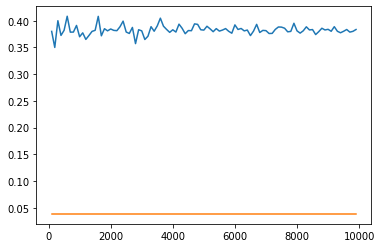

In [ ]:
import matplotlib.pyplot as plt

event = {'R': 'big', 'A': 'adult'}

x = range(100, 10000, 100)
y1 = [calc_probability_sampling(event, i) for i in x]
y2 = [calc_probability(event) for i in x]
plt.plot(x, y1)
plt.plot(x, y2)
plt.show()